<a href="https://colab.research.google.com/github/Ruchika-01/brain-tumor-mobilenetv2-pytorch/blob/main/Brain_Tumour_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# 1) Mount Drive and set ROOT path
from pathlib import Path
import os, shutil, random, glob, pathlib
from google.colab import drive
drive.mount('/content/drive')

# CHANGE THIS ONLY if your folder name differs
ROOT = Path("/content/drive/MyDrive/Brain_Tumour_4_classes_Dataset")
assert ROOT.exists(), f"Not found: {ROOT}"
print("ROOT:", ROOT)
print("ROOT contents:", [p.name for p in ROOT.iterdir()])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ROOT: /content/drive/MyDrive/Brain_Tumour_4_classes_Dataset
ROOT contents: ['Training', 'Testing']


In [23]:
#  2) Build clean splits at /content/brain_splits
from pathlib import Path
import os, shutil, random, glob, pathlib
DEST = Path("/content/brain_splits")
for sub in ["train", "val", "test"]:
    (DEST / sub).mkdir(parents=True, exist_ok=True)

def class_dirs_in(p: Path):
    return sorted([d for d in Path(p).iterdir() if d.is_dir() and not d.name.startswith(".")])

def copy_split(src_root: Path, dest_root: Path = DEST, ratios=(0.8, 0.1, 0.1)):
    classes = class_dirs_in(src_root)
    assert len(classes) >= 2, "Need at least 2 class folders in dataset."
    print("Detected classes:", [c.name for c in classes])
    exts = ("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff")
    for cls in classes:
        files = []
        for ext in exts:
            files += list((cls).glob(ext))
        random.shuffle(files)
        n = len(files)
        n_tr = int(ratios[0]*n)
        n_va = int(ratios[1]*n)
        tr, va, te = files[:n_tr], files[n_tr:n_tr+n_va], files[n_tr+n_va:]
        for split_name, split_files in [("train", tr), ("val", va), ("test", te)]:
            out = dest_root / split_name / cls.name
            out.mkdir(parents=True, exist_ok=True)
            for f in split_files:
                shutil.copy2(f, out)

entries = class_dirs_in(ROOT)
names = {e.name.lower() for e in entries}
has_train = any(k in names for k in ["train", "training"])
has_test  = any(k in names for k in ["test", "testing"])

random.seed(42)
if has_train and has_test:
    print("Using provided Training/Testing; carving 10% from Training for Val.")
    train_dir = [e for e in entries if e.name.lower() in ["train","training"]][0]
    test_dir  = [e for e in entries if e.name.lower() in ["test","testing"]][0]
    classes = class_dirs_in(train_dir)

    for cls in classes:
        imgs = []
        for ext in ("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff"):
            imgs += list((cls).glob(ext))
        random.shuffle(imgs)
        n_val = max(1, int(0.1 * len(imgs)))
        val_imgs = imgs[:n_val]
        tr_imgs  = imgs[n_val:]
        for name, group in [("train", tr_imgs), ("val", val_imgs)]:
            out = DEST / name / cls.name
            out.mkdir(parents=True, exist_ok=True)
            for f in group:
                shutil.copy2(f, out)

    for cls in class_dirs_in(test_dir):
        out = DEST / "test" / cls.name
        out.mkdir(parents=True, exist_ok=True)
        for ext in ("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff"):
            for f in cls.glob(ext):
                shutil.copy2(f, out)

else:
    print("Single folder with class subfolders detected. Creating 80/10/10 split...")
    copy_split(ROOT, ratios=(0.8, 0.1, 0.1))

for sub in ["train","val","test"]:
    print(sub, "classes:", [d.name for d in class_dirs_in(DEST/sub)])


Using provided Training/Testing; carving 10% from Training for Val.
train classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
val classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
test classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [24]:
#  3) Data: transforms, datasets, loaders ====

#  Required imports so this cell runs independently
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

IMG_SIZE = 224
BATCH = 32
NUM_WORKERS = 2

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dir = DEST / "train"
val_dir   = DEST / "val"
test_dir  = DEST / "test"

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=eval_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=eval_tfms)

class_names = train_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [25]:
# 4) Model: choose backbone ====

#  Required imports for this cell
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2, resnet18

# Define device here so this cell runs independently
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BACKBONE = "mobilenetv2"   # "mobilenetv2" or "resnet18"

def build_model(backbone: str, num_classes: int):
    if backbone == "mobilenetv2":
        m = mobilenet_v2(weights="IMAGENET1K_V1")
        m.classifier[1] = nn.Linear(m.last_channel, num_classes)
    elif backbone == "resnet18":
        m = resnet18(weights="IMAGENET1K_V1")
        m.fc = nn.Linear(m.fc.in_features, num_classes)
    else:
        raise ValueError("Unknown backbone")
    return m

model = build_model(BACKBONE, num_classes).to(device)
print(model.__class__.__name__, "ready on", device)


MobileNetV2 ready on cuda


In [26]:
# ==== 5) Training utils ====



#  Required imports for this cell
import torch
import torch.nn as nn

#  Ensure device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Ensure device is defined here for independence
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Ensure loss, optimizer, scheduler, scaler exist inside this cell (not dependent on previous cells)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

def run_epoch(model, loader, train: bool):
    if train:
        model.train()
    else:
        model.eval()

    total = 0
    correct = 0
    total_loss = 0.0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.autocast(
            device_type='cuda',
            dtype=torch.float16,
            enabled=torch.cuda.is_available()
        ):
            logits = model(imgs)
            loss = criterion(logits, labels)

        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        total_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


/tmp/ipython-input-3656859672.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Epoch 01 | train 0.3186/0.888 | val 0.2521/0.918
 Saved best model so far (val acc: 0.918)
Epoch 02 | train 0.1673/0.947 | val 0.0936/0.969
 Saved best model so far (val acc: 0.969)
Epoch 03 | train 0.1044/0.967 | val 0.0357/0.993
 Saved best model so far (val acc: 0.993)
Epoch 04 | train 0.0499/0.983 | val 0.0257/0.993
 Saved best model so far (val acc: 0.993)
Epoch 05 | train 0.0275/0.992 | val 0.0066/0.999
 Saved best model so far (val acc: 0.999)

 Training Complete
Best Validation Accuracy: 0.9990636704119851


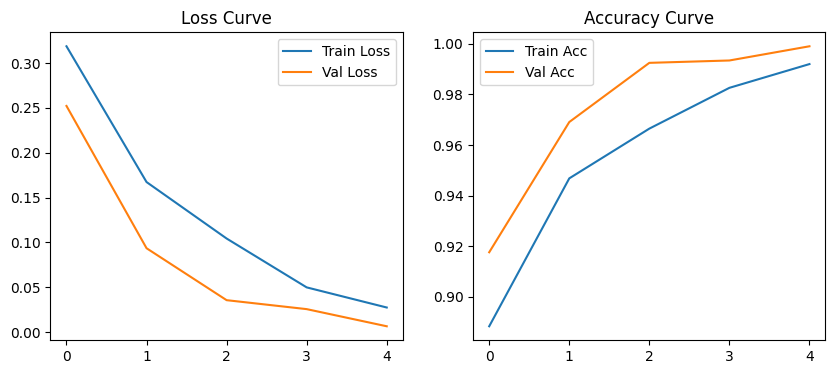

In [27]:
# ==== 6) Train loop ====

#  Required imports for this cell
import torch
import matplotlib.pyplot as plt

#  checking if device exists for independence
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Ensuring checkpoint path exists
from pathlib import Path
CKPT = Path("/content/best_model.pt")

EPOCHS = 5
best_val = 0.0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model, train_loader, train=True)
    val_loss, val_acc = run_epoch(model, val_loader, train=False)


    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_accs.append(tr_acc)
    val_accs.append(val_acc)


    try:
        scheduler.step()
    except:
        pass

    print(f"Epoch {epoch:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | val {val_loss:.4f}/{val_acc:.3f}")

    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), CKPT)
        print(f" Saved best model so far (val acc: {best_val:.3f})")

print("\n Training Complete")
print("Best Validation Accuracy:", best_val)

#  Plot accuracy/loss graphs
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")
plt.show()


In [28]:
print(len(train_ds), len(val_ds), len(test_ds))


5642 1068 1312


              precision    recall  f1-score   support

      glioma     0.9934    0.9967    0.9950       301
  meningioma     0.9934    0.9869    0.9902       306
     notumor     0.9951    1.0000    0.9975       405
   pituitary     1.0000    0.9967    0.9983       300

    accuracy                         0.9954      1312
   macro avg     0.9955    0.9951    0.9953      1312
weighted avg     0.9954    0.9954    0.9954      1312



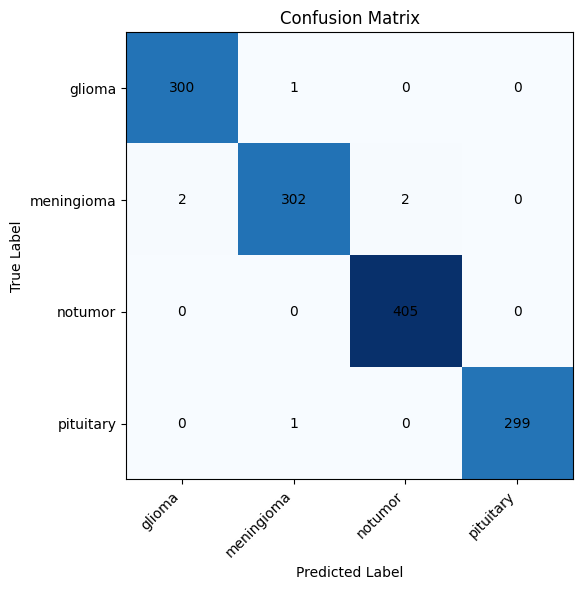

In [29]:
# ==== 7) Test evaluation & reports ====

# Required imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

#  Ensure device exists
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Ensure checkpoint path exists
CKPT = Path("/content/best_model.pt")

# Load best model weights
model.load_state_dict(torch.load(CKPT, map_location=device))
model.eval()

@torch.no_grad()
def predict_all(model, loader):
    y_true = []
    y_pred = []
    for X, y in loader:
        X = X.to(device)
        logits = model(X)
        preds = logits.argmax(dim=1).cpu().numpy().tolist()
        y_pred.extend(preds)
        y_true.extend(y.numpy().tolist())
    return y_true, y_pred

#  test prediction
y_true, y_pred = predict_all(model, test_loader)

#  evaluation report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm, cmap='Blues')
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)

#  Add numbers on matrix
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.tight_layout()
plt.show()


In [35]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-33jc8snq
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-33jc8snq
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


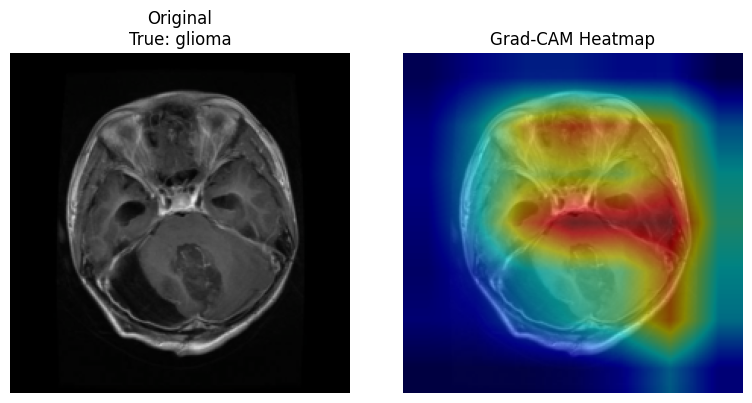

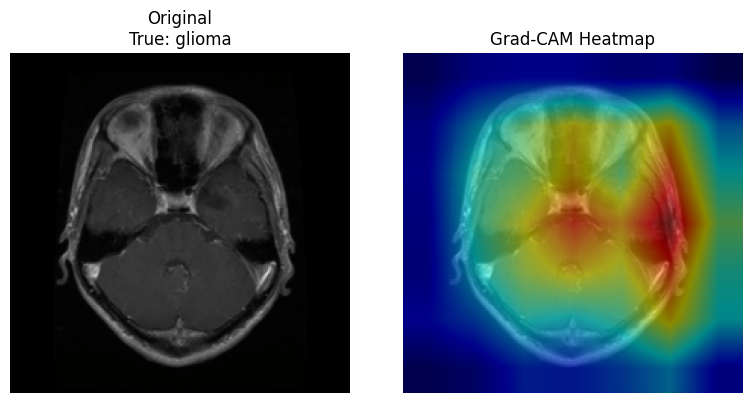

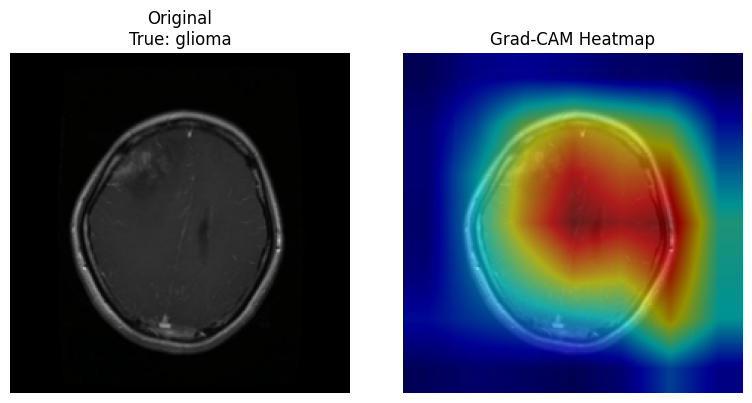

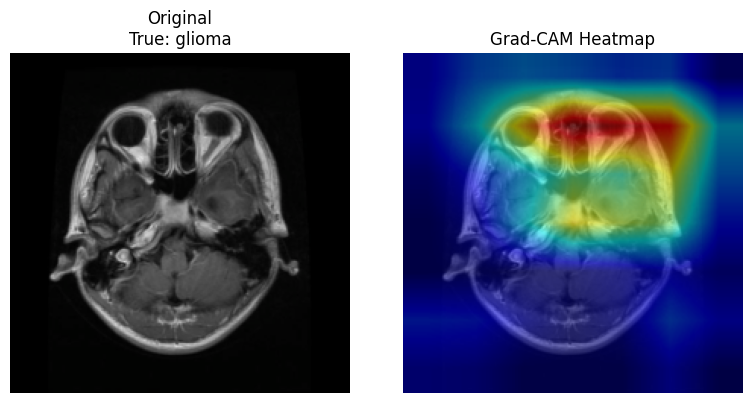

In [41]:
# ==== 8) Grad-CAM for MobileNetV2 (PyTorch 2.x, Python 3.12 compatible) ====


import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from pathlib import Path

# Grad-CAM imports (note: module name is pytorch_grad_cam)
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inverse normalization to visualize images nicely
inv_norm = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

def tensor_to_vis(img_tensor):
    # img_tensor: CxHxW normalized
    return inv_norm(img_tensor).clamp(0,1).permute(1,2,0).cpu().numpy()

# Load best checkpoint and ensure eval mode
CKPT = Path("/content/best_model.pt")
model.load_state_dict(torch.load(CKPT, map_location=device))
model.to(device).eval()

# Pick a real Conv2d layer inside the last MobileNetV2 block (robust across versions)
last_block = model.features[-1]         # ConvBNReLU wrapper
target_layer = getattr(last_block, '0', last_block)  # prefer inner Conv2d if present

# Take a small batch from test set
imgs, labels = next(iter(test_loader))
imgs_gpu = imgs.to(device)

# Build CAM with context manager (cleans up hooks properly)
with GradCAM(model=model, target_layers=[target_layer]) as cam:
    # Highest-scoring class per image by default
    grayscale_cams = cam(input_tensor=imgs_gpu)

# ✅ Show original + Grad-CAM side-by-side
n_show = min(4, len(imgs))

for i in range(n_show):
    rgb = tensor_to_vis(imgs[i])
    overlay = show_cam_on_image(rgb, grayscale_cams[i], use_rgb=True)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Original image
    axes[0].imshow(rgb)
    axes[0].set_title(f"Original\nTrue: {class_names[labels[i].item()]}")
    axes[0].axis("off")

    # Grad-CAM overlay
    axes[1].imshow(overlay)
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


In [42]:
# ==== 9) Prediction Gallery (Original + Grad-CAM + Labels) ====

# Install (works on Colab Py3.12 / Torch 2.x)
!pip -q install git+https://github.com/jacobgil/pytorch-grad-cam.git

# Imports
import os, random
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inverse normalization for pretty RGB
inv_norm = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485,0.456,0.406],[0.229,0.224,0.225])],
    std=[1/s for s in [0.229,0.224,0.225]]
)
def tensor_to_vis(img_tensor):  # CxHxW -> HxWx3, [0,1]
    return inv_norm(img_tensor).clamp(0,1).permute(1,2,0).cpu().numpy()

# Load best model (assumes model/test_loader/class_names in memory from prior cells)
CKPT = Path("/content/best_model.pt")
model.load_state_dict(torch.load(CKPT, map_location=device))
model.to(device).eval()

# Pick a robust MobileNetV2 target conv layer for CAM
last_block = model.features[-1]                # ConvBNReLU wrapper
target_layer = getattr(last_block, '0', last_block)  # inner Conv2d if present, else wrapper

# Output folders
SAVE_ROOT = Path("/content/brain_outputs")
(SAVE_ROOT / "gallery").mkdir(parents=True, exist_ok=True)
(SAVE_ROOT / "misclassified").mkdir(parents=True, exist_ok=True)

def generate_gallery(n_samples=12, misclassified_only=False, seed=123):
    random.seed(seed)
    saved = 0
    samples = []

    # Precollect up to a few batches to draw from
    for X, y in test_loader:
        with torch.no_grad():
            logits = model(X.to(device))
            preds = logits.argmax(1).cpu()
        for i in range(len(X)):
            is_miss = preds[i].item() != y[i].item()
            if (not misclassified_only and saved < n_samples) or (misclassified_only and is_miss and saved < n_samples):
                samples.append((X[i], y[i].item(), preds[i].item()))
                saved += 1
        if saved >= n_samples:
            break
    return samples

def save_side_by_side(img_tensor, cam_map, true_idx, pred_idx, out_path):
    rgb = tensor_to_vis(img_tensor)
    overlay = show_cam_on_image(rgb, cam_map, use_rgb=True)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(rgb);  axes[0].axis("off")
    axes[0].set_title(f"Original\nTrue: {class_names[true_idx]}")
    axes[1].imshow(overlay); axes[1].axis("off")
    axes[1].set_title(f"Grad-CAM\nPred: {class_names[pred_idx]}")
    plt.tight_layout()
    fig.savefig(out_path, dpi=180, bbox_inches="tight")
    plt.close(fig)

def run_cam_and_save(samples, out_dir):
    # Build CAM once per batch size used
    with GradCAM(model=model, target_layers=[target_layer]) as cam:
        # Batch CAM for speed
        batch = torch.stack([s[0] for s in samples]).to(device)
        grayscale_cams = cam(input_tensor=batch)  # highest-score class by default

    for i, (img_t, true_idx, pred_idx) in enumerate(samples):
        fname = f"{i:02d}_true-{class_names[true_idx]}_pred-{class_names[pred_idx]}.png"
        save_side_by_side(img_t, grayscale_cams[i], true_idx, pred_idx, Path(out_dir) / fname)

# A) Random gallery (good representative cases)
gallery_samples = generate_gallery(n_samples=12, misclassified_only=False, seed=1337)
run_cam_and_save(gallery_samples, SAVE_ROOT / "gallery")

# B) Misclassifications (if any)
miss_samples = generate_gallery(n_samples=12, misclassified_only=True, seed=2025)
if len(miss_samples) > 0:
    run_cam_and_save(miss_samples, SAVE_ROOT / "misclassified")

print("Saved:")
print(f" - Gallery:        {len(gallery_samples)} images -> {SAVE_ROOT/'gallery'}")
print(f" - Misclassified:  {len(miss_samples)} images -> {SAVE_ROOT/'misclassified'}")


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Saved:
 - Gallery:        12 images -> /content/brain_outputs/gallery
 - Misclassified:  6 images -> /content/brain_outputs/misclassified


In [44]:
!pip -q install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.8 MB/s eta 0:00:00


In [45]:
import torch
from pathlib import Path
import onnx, onnxruntime as ort

# Paths
DRIVE_ROOT = Path("/content/drive/MyDrive/Brain_Tumour_4_classes_Project")
DRIVE_ROOT.mkdir(parents=True, exist_ok=True)
onnx_path = DRIVE_ROOT / "artifacts" / "mobilenetv2_brain_tumor.onnx"
onnx_path.parent.mkdir(parents=True, exist_ok=True)

# Model to CPU + eval
model.eval().to("cpu")

# Dummy input
dummy = torch.randn(1, 3, 224, 224)

# Export with the new (dynamo) exporter; falls back to legacy if not supported
try:
    torch.onnx.export(
        model,
        dummy,
        str(onnx_path),
        input_names=["input"],
        output_names=["logits"],
        opset_version=17,
        dynamic_axes={"input": {0: "batch"}, "logits": {0: "batch"}},
        dynamo=True,                # use new exporter
    )
    print("Exported with dynamo=True")
except Exception as e:
    print("Dynamo export failed, trying legacy exporter. Reason:", e)
    torch.onnx.export(
        model,
        dummy,
        str(onnx_path),
        input_names=["input"],
        output_names=["logits"],
        opset_version=12,
        dynamic_axes={"input": {0: "batch"}, "logits": {0: "batch"}},
        dynamo=False,
    )
    print("Exported with legacy exporter")

# Validate the ONNX graph
onnx_model = onnx.load(str(onnx_path))
onnx.checker.check_model(onnx_model)
print("ONNX model is valid:", onnx_path)

# Quick ONNXRuntime inference sanity check
ort_sess = ort.InferenceSession(str(onnx_path), providers=["CPUExecutionProvider"])
import numpy as np
x = np.random.randn(1,3,224,224).astype(np.float32)
outputs = ort_sess.run(["logits"], {"input": x})[0]
print("ONNX logits shape:", outputs.shape)


Dynamo export failed, trying legacy exporter. Reason: No module named 'onnxscript'


/tmp/ipython-input-1743302116.py:32: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Exported with legacy exporter
ONNX model is valid: /content/drive/MyDrive/Brain_Tumour_4_classes_Project/artifacts/mobilenetv2_brain_tumor.onnx
ONNX logits shape: (1, 4)


In [49]:
!find /content/drive -maxdepth 6 -name "*.ipynb"


/content/drive/MyDrive/Colab Notebooks/Untitled0.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled1.ipynb
/content/drive/MyDrive/Colab Notebooks/PGMdemo.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled3.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled4.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled5.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled7.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled2.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled6.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled8.ipynb
/content/drive/MyDrive/Colab Notebooks/Copy of Untitled9.ipynb
/content/drive/MyDrive/Colab Notebooks/MNIST2.ipynb
/content/drive/MyDrive/Colab Notebooks/Digit Generation with Autoregressive Neural Networks.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled9.ipynb
/content/drive/MyDrive/Colab Notebooks/size.ipynb
/content/drive/MyDrive/Colab Notebooks/SAM.ipynb
/content/drive/MyDrive/Colab Notebooks/SAM2.ipynb
/content/drive/MyDrive/Colab Notebo

In [50]:
from pathlib import Path
import shutil, os, textwrap

PROJECT = Path("/content/brain_tumor_mobilenetv2")
PROJECT.mkdir(parents=True, exist_ok=True)

# Copy the notebook from Drive
src_nb = Path("/content/drive/MyDrive/Brain_Tumour_4_classes_Project/Brain_Tumour_classification.ipynb")
dst_nb = PROJECT / "BrainTumor_MobileNetV2.ipynb"
shutil.copy2(src_nb, dst_nb)

# Create minimal README and requirements if missing
readme = PROJECT / "README.md"
if not readme.exists():
    readme.write_text(textwrap.dedent("""\
        # Brain Tumor MRI Classification (PyTorch MobileNetV2 + Grad-CAM)

        - Task: 4-class MRI classification (glioma, meningioma, pituitary, no-tumor)
        - Backbone: MobileNetV2 (transfer learning, PyTorch)
        - Explainability: Grad-CAM overlays
        - Test Acc ~99.4% (balanced per-class F1 > 0.98)

        Run in Colab and follow the cells in the notebook.
    """))

req = PROJECT / "requirements.txt"
if not req.exists():
    req.write_text(textwrap.dedent("""\
        torch
        torchvision
        scikit-learn
        matplotlib
        numpy
        onnx
        onnxruntime
        git+https://github.com/jacobgil/pytorch-grad-cam.git
    """))

gi = PROJECT / ".gitignore"
if not gi.exists():
    gi.write_text(textwrap.dedent("""\
        __pycache__/
        .ipynb_checkpoints/
        *.pt
        *.pth
        *.onnx
        *.ckpt
        *.npz
        *.npy
        brain_outputs/
        artifacts/
    """))

print("Prepared:", PROJECT)
print(os.listdir(PROJECT))


Prepared: /content/brain_tumor_mobilenetv2
['.gitignore', 'BrainTumor_MobileNetV2.ipynb', 'README.md', 'requirements.txt']


In [51]:
# Configure Git (set your real name/email)
!git config --global user.name "Your Name"
!git config --global user.email "you@example.com"

# Init, add, commit
%cd /content/brain_tumor_mobilenetv2
!git init
!git add .
!git commit -m "Initial commit: MobileNetV2 MRI + Grad-CAM notebook"


/content/brain_tumor_mobilenetv2
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/brain_tumor_mobilenetv2/.git/
[master (root-commit) 2c4b85a] Initial commit: MobileNetV2 MRI + Grad-CAM notebook
 4 files changed, 27 insertions(+)
 create mode 100644 .gitignore
 create mode 100644 BrainTumor_MobileNetV2.ipynb
 create mode 100644 README.md
 create mode 100644 requirements.txt
